# Détecteur de stéréotypes


In [1]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [2]:
# Imports
import json
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from mistralai import Mistral
from tqdm.auto import tqdm
from pyfonts import load_google_font
from aquarel import load_theme

load_dotenv()
tqdm.pandas()

## Importation et simplification des données


In [3]:
df = pd.read_csv("./dataset/rtbfCorpus.csv", sep="|", encoding="utf-8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767204 entries, 0 to 767203
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 767204 non-null  int64 
 1   pub_date           767204 non-null  object
 2   feed               767204 non-null  object
 3   category           759930 non-null  object
 4   keyword            644449 non-null  object
 5   signature          763736 non-null  object
 6   title              767202 non-null  object
 7   text_html          767204 non-null  object
 8   text_cleaned       767204 non-null  object
 9   test_preprocessed  767201 non-null  object
dtypes: int64(1), object(9)
memory usage: 58.5+ MB


In [5]:
# Filter the DataFrame for the "MONDE" category
df_monde = df[df["category"].isin(["MONDE", "SOCIETE"])]
df_monde.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153512 entries, 48 to 767150
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 153512 non-null  int64 
 1   pub_date           153512 non-null  object
 2   feed               153512 non-null  object
 3   category           153512 non-null  object
 4   keyword            129693 non-null  object
 5   signature          153512 non-null  object
 6   title              153512 non-null  object
 7   text_html          153512 non-null  object
 8   text_cleaned       153512 non-null  object
 9   test_preprocessed  153512 non-null  object
dtypes: int64(1), object(9)
memory usage: 12.9+ MB


In [6]:
distinct_keywords = df_monde["keyword"].unique()
distinct_keywords


array(['LOISIRS', 'FAITS DIVERS', 'DIVERS', nan, 'AMERIQUE DU SUD',
       'ASIE', 'DEFENSE', 'RELIGION', 'SANTE', 'EUROPE', 'MOYEN ORIENT',
       'AFRIQUE', 'POLITIQUE', 'AMERIQUE DU NORD', 'MOBILITE', 'JUSTICE',
       'ENERGIE', 'INSOLITE', 'ENVIRONNEMENT', 'CONSOMMATION', 'DROGUES',
       'AMERIQUE CENTRALE', 'ENSEIGNEMENT', 'AGRICULTURE', 'ESPACE',
       'SCIENCES', 'LITTERATURE', 'SYNDICALISME', 'CATASTROPHES',
       'TECHNOLOGIE', 'IMMIGRATION', 'MUSIQUE', 'JEUNESSE', 'BEAUX ARTS',
       'OCEANIE', 'INTERNET', 'REGION DE BRUXELLES', 'CINEMA', 'PEOPLE',
       'TERRORISME', 'AERONAUTIQUE', 'ENTREPRISES', 'EMPLOI', 'ECONOMIE',
       'CATASTROPHE', 'CONFLITS', 'AUTOMOBILE', 'FLANDRE OCCIDENTALE',
       'ANVERS', 'MONARCHIE', 'SPECTACLES', 'HAINAUT', 'MER', 'LIMBOURG',
       'DEVISES', 'LIEGE', 'BRABANT WALLON', 'NAMUR', 'LUXEMBOURG',
       'FLANDRE ORIENTALE', 'BRABANT FLAMAND'], dtype=object)

In [7]:
keywords_to_filter_out = [
    "AMERIQUE DU SUD",
    "ASIE",
    "AMERIQUE CENTRALE",
    "AMERIQUE DU NORD",
    "REGION DE BRUXELLES",
    "SPECTACLES",
    "OCEANIE",
    "NAMUR",
    "LOISIRS",
    "FLANDRE OCCIDENTALE",
    "LIMBOURG",
    "LUXEMBOURG",
    "BRABANT WALLON",
    "BRABANT FLAMAND",
    "FLANDRE ORIENTALE",
    "ANVERS",
    "LIEGE",
    "HAINAUT",
]
mask = df_monde["keyword"].isin(keywords_to_filter_out)
df_monde_restreint = df_monde[~mask]

## Sampling pour protoyper


In [8]:
sr = df_monde_restreint
sr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135983 entries, 60 to 767150
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 135983 non-null  int64 
 1   pub_date           135983 non-null  object
 2   feed               135983 non-null  object
 3   category           135983 non-null  object
 4   keyword            112164 non-null  object
 5   signature          135983 non-null  object
 6   title              135983 non-null  object
 7   text_html          135983 non-null  object
 8   text_cleaned       135983 non-null  object
 9   test_preprocessed  135983 non-null  object
dtypes: int64(1), object(9)
memory usage: 11.4+ MB


## Stéréotypes


In [19]:
stereotypes = {
    "guerre_complot": {
        "id": "guerre_complot",
        "canonical_form": "La guerre en Syrie est un complot extérieur, et non une révolution syrienne.",
        "description": (
            "Stéréotype central : les événements de 2011 et la guerre en Syrie ne seraient pas l'expression d'un soulèvement populaire, mais le résultat d'un complot élaboré par des forces extérieures (islamistes, sionistes, américaines, impérialistes, etc.), avec des Syriens réduits au rôle de marionnettes ou de dupes. Cette lecture complotiste s'appuie sur une histoire réelle de coups d'État, d'ingérences et de plans secrets, mais elle en fait une grille déterministe qui nie la capacité des Syriens à se soulever et à se représenter eux-mêmes."
        ),
        "variants": [
            "La guerre en Syrie est un complot",
            "Ce qui se passe en Syrie est un complot",
            "Les événements en Syrie sont une conspiration étrangère",
            "Il n'y a pas de révolution en Syrie, seulement un complot",
            "Le soulèvement syrien est manipulé de l'étranger",
            "C'est une guerre orchestrée par des puissances étrangères",
            "Les Syriens sont les victimes d'un plan secret",
            "Ce n'est pas une révolution, c'est une machination internationale",
        ],
        # Mots qui doivent presque toujours être là si on parle vraiment de ce stéréotype
        "mandatory_keywords": ["Syrie", "guerre"],
        # Liste large pour le pré-filtrage
        "keywords": [
            "Syrie",
            "guerre",
            "complot",
            "conspiration",
            "ingérence",
            "ingérences",
            "manipulation",
            "marionnettes",
            "agents de l'étranger",
            "impérialiste",
            "impérialistes",
            "axe de la résistance",
            "ingérences étrangères",
            "puissances étrangères",
        ],
        "sub_stereotypes": [
            {
                "id": "complot_islamiste",
                "canonical_form": "La guerre en Syrie est un complot islamiste contre un régime laïc protecteur des minorités.",
                "description": (
                    "Idée reçue : le soulèvement serait avant tout une entreprise islamiste ou jihadiste visant à abattre "
                    "un régime présenté comme laïc et protecteur des minorités. Les manifestants sont décrits comme "
                    "des extrémistes manipulés par des islamistes, et non comme des citoyens porteurs de revendications "
                    "politiques. Cette lecture participe à la disqualification de la révolution et à la peur des 'majorités sunnites'."
                ),
                "variants": [
                    "C'est un complot islamiste contre un régime laïc",
                    "Les islamistes ont monté un complot contre le régime syrien",
                    "Les extrémistes religieux sont derrière la guerre en Syrie",
                    "Les manifestants sont des islamistes manipulés",
                    "La crise syrienne est un complot des islamistes",
                ],
                "keywords": [
                    "islamistes",
                    "islamiste",
                    "extrémistes",
                    "extrémisme",
                    "régime laïc",
                    "minorités",
                    "chrétiens",
                    "alaouites",
                    "protection des minorités",
                    "fondamentalistes",
                ],
            },
            {
                "id": "complot_sioniste",
                "canonical_form": "La guerre en Syrie est un complot sioniste contre l'axe de la résistance à Israël.",
                "description": (
                    "Idée reçue : la crise syrienne serait une conspiration sioniste destinée à affaiblir la Syrie et l'axe "
                    "de la résistance (Syrie, Hezbollah, Iran). Les manifestants sont alors décrits comme des marionnettes "
                    "de Tel-Aviv ou de 'l'ennemi sioniste'. Cette lecture réactive un imaginaire ancien de complot contre la nation arabe."
                ),
                "variants": [
                    "La guerre en Syrie est un complot sioniste",
                    "C'est un plan israélien contre la Syrie",
                    "Les sionistes veulent détruire la Syrie",
                    "Les manifestants sont des agents d'Israël",
                    "Un complot contre l'axe de la résistance",
                ],
                "keywords": [
                    "Israël",
                    "sioniste",
                    "sionistes",
                    "Tel-Aviv",
                    "axe de la résistance",
                    "Hezbollah",
                    "Iran",
                    "ennemi sioniste",
                    "nation arabe",
                ],
            },
            {
                "id": "complot_americain",
                "canonical_form": "La guerre en Syrie est un complot américain pour remodeler la région et renverser des régimes ennemis.",
                "description": (
                    "Idée reçue : la contestation de 2011 serait une opération américaine de déstabilisation, pour remodeler "
                    "le Moyen-Orient, contrôler la Syrie et l'arracher à l'axe russo-iranien. Cette théorie s'appuie sur des éléments "
                    "réels (politique de Bush, câbles diplomatiques, pression sur Damas), mais en fait un récit totalisant qui "
                    "ignore les dynamiques internes et les évolutions politiques américaines (ex. l'élection d'Obama et le recul de l'agenda néoconservateur)."
                ),
                "variants": [
                    "La Syrie est la cible d'un complot américain",
                    "Les États-Unis ont déclenché la crise syrienne",
                    "La guerre en Syrie fait partie d'un plan américain pour redessiner le Moyen-Orient",
                    "Les Américains manipulent l'opposition syrienne",
                    "C'est un complot de Washington contre Damas",
                ],
                "keywords": [
                    "États-Unis",
                    "américain",
                    "américaine",
                    "Washington",
                    "néoconservateur",
                    "ingérence américaine",
                    "remodeler le Moyen-Orient",
                    "déstabilisation",
                    "Khaddam",
                    "résolution 1559",
                ],
            },
            {
                "id": "guerre_pour_le_petrole",
                "canonical_form": "La guerre en Syrie est une guerre pour le pétrole, le gaz et les pipelines.",
                "description": (
                    "Idée reçue : la crise syrienne serait avant tout une guerre pour le contrôle des ressources énergétiques, "
                    "du gaz et des gazoducs transitant par le territoire syrien (projet qatari, 'stratégie des cinq mers', etc.). "
                    "Cette lecture transpose sur la Syrie le schéma des 'guerres pour le pétrole' (Irak 2003) en minimisant "
                    "les causes propres au soulèvement syrien et la faiblesse relative des ressources syriennes."
                ),
                "variants": [
                    "La guerre en Syrie est une guerre pour le pétrole",
                    "La crise syrienne est liée au gaz et aux pipelines",
                    "Tout tourne autour des gazoducs en Syrie",
                    "Les Occidentaux veulent s'emparer des ressources syriennes",
                    "Un complot énergétique autour des pipelines syriens",
                ],
                "keywords": [
                    "pétrole",
                    "gaz",
                    "gazoduc",
                    "gazoducs",
                    "pipeline",
                    "pipelines",
                    "énergie",
                    "hydrocarbures",
                    "stratégie des cinq mers",
                ],
            },
            {
                "id": "attaques_chimiques_false_flag",
                "canonical_form": "Les attaques chimiques en Syrie sont des mises en scène ou de faux drapeaux pour justifier une intervention.",
                "description": (
                    "Idée reçue : les attaques chimiques (Ghouta, Khan Cheikhoun, etc.) seraient des mises en scène de l'opposition "
                    "ou de puissances étrangères pour justifier une intervention contre le régime (opérations 'false flag'). "
                    "Ce récit ignore ou relativise les enquêtes de l'OIAC-ONU attribuant la plupart des attaques au régime syrien, "
                    "et s'accompagne souvent d'une campagne de disqualification des Casques blancs, accusés d'être liés à Al-Qaïda "
                    "et de manipuler les images des bombardements."
                ),
                "variants": [
                    "Les attaques chimiques sont une mise en scène",
                    "Les gazages en Syrie sont un false flag",
                    "Les rebelles ont mis en scène l'attaque chimique",
                    "Les Occidentaux ont fabriqué les preuves d'armes chimiques",
                    "Les Casques blancs montent de fausses vidéos",
                ],
                "keywords": [
                    "attaque chimique",
                    "attaques chimiques",
                    "armes chimiques",
                    "Ghouta",
                    "Khan Cheikhoun",
                    "gaz sarin",
                    "false flag",
                    "faux drapeau",
                    "mise en scène",
                ],
            },
        ],
    },
}


## Rôle

Tu es un assistant qui analyse des articles de journaux pour détecter un certain type de stéréotype / idée reçue concernant la Syrie.

Stéréotype à détecter (ID: assad_vs_daech) : **"Le conflit syrien se résume à un duel : soit Assad, soit Daech."**
Description: Assad serait le seul rempart contre Daech. Cette vision binaire efface la pluralité des acteurs (opposition modérée, groupes locaux, factions civiles, Kurdes, islamistes non jihadistes).Elle est souvent mobilisée pour justifier le maintien du régime.

De ce stéréotype découlent d'autres idées reçues analogues:

- **"L'opposition syrienne est fondamentalement islamiste ou jihadiste."** : l'opposition est décrite comme un bloc islamiste, effaçant sa diversité (civile, laïque, minoritaire, armée non jihadiste). Cette vision s'appuie souvent sur des références au Friday protests, au takbîr, ou à l'influence des Frères musulmans.
- **"Il n'existe pas d'opposition syrienne crédible ou significative."** : la révolution syrienne n'a pas produit d'opposition structurée. Cela nie l'existence des comités locaux, de l'Armée syrienne libre, des institutions civiles locales et des cadres politiques du CNS.
- **La révolution syrienne est un soulèvement sunnite confessionnel.** : le conflit syrien serait avant tout confessionnel ou communautaire. En réalité, les revendications initiales étaient politiques, et que des figures minoritaires participèrent au soulèvement.

Variantes possibles de ce stéréotype :

- "C'est Assad ou Daech"
- "Assad est le seul rempart contre Daech"
- "Sans Assad, Daech prendra le pouvoir"
- "Assad ou les terroristes"
- "Assad ou le chaos"
- "Assad ou les islamistes"
- "Il n'y a pas d'alternative à Assad"
- "Entre Assad et Daech il n'y a rien"
- "Le régime protège la Syrie du terrorisme"

## Tâche

Je te donne un article de journal. Tu dois l'analyser et identifier si le stéréotype ci-dessus est présent, si oui sous quelle forme, et pourquoi.
Réponds STRICTEMENT au format JSON suivant (sans texte additionnel) :

```json
{
  "stereotype_id": "assad_vs_daech",
  "present": "yes" | "no" | "uncertain",
  "mode": "reproduit" | "nuancé" | "critiqué" | "non_pertinent",
  "intensite": "évoqué" | "présent" | "dominant" | "omniprésent" | "non_pertinent",
  "resume": "Très court résumé du contenu de l'article. Trois phrases maximum.",
  "justification": "Courte argumentation quant à la présence du stéréotype dans l'article. Laisser vide si le stéréotype est absent.",
}
```


In [20]:
mandatory_keywords = stereotypes["guerre_complot"]["mandatory_keywords"]


def contains_all_mandatory(text, keywords):
    if not isinstance(text, str):
        return False
    for kw in keywords:
        if not re.search(r"\b" + re.escape(kw) + r"\b", text, flags=re.IGNORECASE):
            return False
    return True


sr_keywords = sr[
    sr["text_cleaned"].progress_apply(
        lambda t: contains_all_mandatory(t, mandatory_keywords)
    )
]
sr_keywords.info()

  0%|          | 0/135983 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 2675 entries, 3610 to 767012
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 2675 non-null   int64 
 1   pub_date           2675 non-null   object
 2   feed               2675 non-null   object
 3   category           2675 non-null   object
 4   keyword            2639 non-null   object
 5   signature          2675 non-null   object
 6   title              2675 non-null   object
 7   text_html          2675 non-null   object
 8   text_cleaned       2675 non-null   object
 9   test_preprocessed  2675 non-null   object
dtypes: int64(1), object(9)
memory usage: 229.9+ KB


In [21]:
def count_keywords(text, keywords):
    count = 0
    for kw in keywords:
        # recherche de mots entiers \b...\b (très important)
        if re.search(r"\b" + re.escape(kw) + r"\b", text, flags=re.IGNORECASE):
            count += 1
    return count

In [23]:
all_keywords = set()

for word in stereotypes["guerre_complot"]["keywords"]:
    all_keywords.add(word.lower())

for sub_stereotype in stereotypes["guerre_complot"]["sub_stereotypes"]:
    for word in sub_stereotype["keywords"]:
        all_keywords.add(word.lower())

sr_keywords["keyword_count"] = sr_keywords["text_cleaned"].progress_apply(
    lambda t: count_keywords(t, all_keywords)
)


  0%|          | 0/2675 [00:00<?, ?it/s]

/tmp/ipykernel_46426/3361720344.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["keyword_count"] = sr_keywords["text_cleaned"].progress_apply(


In [32]:
MIN_KEYWORDS = 3
sr_ready = sr_keywords[sr_keywords["keyword_count"] == MIN_KEYWORDS]
sr_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 594 entries, 17885 to 766787
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 594 non-null    int64 
 1   pub_date           594 non-null    object
 2   feed               594 non-null    object
 3   category           594 non-null    object
 4   keyword            592 non-null    object
 5   signature          594 non-null    object
 6   title              594 non-null    object
 7   text_html          594 non-null    object
 8   text_cleaned       594 non-null    object
 9   test_preprocessed  594 non-null    object
 10  keyword_count      594 non-null    int64 
dtypes: int64(2), object(9)
memory usage: 55.7+ KB


## LLM


In [33]:
MISTRAL_API_KEY = os.environ.get("MISTRAL_API_KEY")
AGENT_ID = os.environ.get("AGENT_ID")

client = Mistral(api_key=MISTRAL_API_KEY)

In [34]:
def strip_fenced_json(text: str) -> str:
    """
    If `text` is enclosed in triple-backtick fences (optionally with a language
    spec like ```json), return the inner content trimmed; otherwise return the
    trimmed original text.

    Examples:
    - "```json\n{\"a\":1}\n```" -> "{\"a\":1}"
    - "``` \n{\n  \"a\": 1\n}\n```" -> "{\n  \"a\": 1\n}"
    - "{\"a\":1}" -> "{\"a\":1}"
    """
    if not isinstance(text, str):
        return text

    # Accept fences like ```json, ``` json, ```anylang or plain ```
    # Capture everything between the first opening ```... and the last closing ```
    m = re.search(
        r"^\s*```(?:\s*\w+)?\s*[\r\n]?([\s\S]*?)\s*```\s*$", text, flags=re.IGNORECASE
    )
    if m:
        return m.group(1).strip()

    return text.strip()


def parse_fenced_json(text: str):
    """
    Convenience: strip fences then attempt to parse JSON. Raises json.JSONDecodeError
    if the inner text is not valid JSON.
    """
    inner = strip_fenced_json(text)
    return json.loads(inner)

In [35]:
def analyze_article_with_mistral(article_title: str, article_text: str):
    inputs = [
        {
            "role": "user",
            "content": "Title: " + article_title + "\n\nArticle:\n" + article_text,
        }
    ]
    completion_args = {"temperature": 0.7, "max_tokens": 2048, "top_p": 1}
    tools = []

    raw_response = client.beta.conversations.start(
        inputs=inputs,
        model="mistral-small-latest",
        instructions="""## Rôle\n\nTu es un assistant qui analyse des articles de journaux pour détecter un certain type de stéréotype / idée reçue concernant la Syrie.\n\nStéréotype à détecter (ID: `guerre_complot`) :\n**"La guerre en Syrie est un complot extérieur, et non une révolution syrienne."**\n\n**Description :**\nLes événements de 2011 et la guerre en Syrie ne seraient pas l'expression d'un soulèvement populaire, mais le résultat d'un complot élaboré par des forces extérieures (islamistes, sionistes, américaines, impérialistes, etc.). Les Syriens y sont réduits au rôle de marionnettes ou de dupes. Cette lecture complotiste s'appuie sur une histoire réelle d'ingérences et de plans secrets, mais elle en fait une grille déterministe qui nie la capacité des Syriens à se soulever et à se représenter eux-mêmes.\n\nDe ce stéréotype central découlent plusieurs idées reçues analogues et sous-stéréotypes fréquents dans les discours :\n\n* **"La guerre en Syrie est un complot islamiste contre un régime laïc protecteur des minorités."**\n  Le soulèvement serait avant tout une entreprise islamiste ou jihadiste visant à abattre un régime présenté comme laïc et protecteur des minorités. Les manifestants sont décrits comme des extrémistes manipulés par des islamistes, et non comme des citoyens porteurs de revendications politiques.\n\n* **"La guerre en Syrie est un complot sioniste contre l'axe de la résistance."**\n  La crise syrienne serait une conspiration sioniste destinée à affaiblir la Syrie et l’axe de la résistance (Syrie, Hezbollah, Iran). Les manifestants sont présentés comme des marionnettes de Tel-Aviv ou de "l'ennemi sioniste".\n\n* **"La guerre en Syrie est un complot américain pour remodeler la région."**\n  La contestation de 2011 serait une opération américaine de déstabilisation pour redessiner le Moyen-Orient, renverser des régimes ennemis et arracher la Syrie à l’axe russo-iranien. L’ingérence américaine est présentée comme la cause première des événements.\n\n* **"La guerre en Syrie est une guerre pour le pétrole, le gaz et les pipelines."**\n  La crise syrienne serait avant tout une guerre pour le contrôle des ressources énergétiques et des gazoducs (projet qatari, pipelines, etc.), calquée sur le schéma des “guerres pour le pétrole”.\n\n* **"Les attaques chimiques en Syrie sont des mises en scène / false flag."**\n  Les attaques chimiques (par exemple à la Ghouta ou à Khan Cheikhoun) seraient des mises en scène de l’opposition ou de puissances étrangères pour justifier une intervention contre le régime. Ce discours s’accompagne souvent d’accusations visant les Casques blancs (White Helmets) accusés de manipuler ou de fabriquer des preuves.\n\nVariantes possibles de ce stéréotype et formulations analogues (liste non exhaustive) :\n\n* "La guerre en Syrie est un complot"\n* "Ce qui se passe en Syrie est une conspiration étrangère"\n* "Il n'y a pas de révolution en Syrie, seulement un complot"\n* "Le soulèvement syrien est manipulé de l'étranger"\n* "C’est une guerre orchestrée par des puissances étrangères"\n* "Les Syriens sont les victimes d’un plan secret"\n* "Les islamistes ont monté un complot contre le régime syrien"\n* "La guerre en Syrie est un complot sioniste / américain"\n* "La crise syrienne est une guerre pour le gaz, les gazoducs, les pipelines"\n* "Les attaques chimiques sont une mise en scène / un false flag"\n* "Les Occidentaux ont fabriqué les preuves d’armes chimiques"\n* "Les Casques blancs montent de fausses vidéos"\n\nTu dois considérer comme relevant du stéréotype **tout discours qui présente la guerre ou le soulèvement en Syrie avant tout comme une machination organisée de l’extérieur**, en niant ou minimisant l’existence d’un mouvement révolutionnaire interne.\n\n## Tâche\n\nJe te donne un article de journal. Tu dois l’analyser et identifier si le stéréotype ci-dessus est présent, et si oui sous quelle forme, et pourquoi. Notamment :\n\n* `"present"` : indique si le thème de cette idée reçue est abordé dans l’article, peu importe que l’article adopte ou critique cette idée.\n\n  * Exemple : si l’article explique qu’il est faux de voir la guerre en Syrie comme un complot extérieur et qu’il critique cette vision, alors `"present"` doit être `"yes"` (le stéréotype est bien présent comme objet de discussion, même pour être réfuté). De même, si l'article parle de la guerre en Syrie comme la manifestation des revendications de la population syrienne, alors `"present"` doit être `"yes"` aussi (le stéréotype est bien présent, implicitement, puisque implicitement, l'article réfute la thèse du complot et rend légitime la guerre)\n\n* `"mode"` : détermine le positionnement de l’article face à l’idée reçue.\n\n  * `"reproduit"` : l’article reprend cette idée de complot comme vraie ou probable, sans la questionner.\n  * `"nuancé"` : l’article mentionne des éléments complotistes mais les met en balance avec d’autres explications, ou reste ambigu.\n  * `"critiqué"` : l’article remet clairement en cause cette lecture complotiste, la déconstruit, la contredit (que ce soit explicitement ou implicitement, comme dans l'exemple ci-dessus)\n  * `"non_pertinent"` : l’article ne traite pas du tout de ce thème, ou le mentionne de manière tellement marginale que ce n’est pas significatif.\n\n* `"intensite"` : détermine à quel point le stéréotype est central dans l’article, peut importe la position de l'article à son sujet, sur l’échelle suivante :\n\n  * `"évoqué"` : le stéréotype ou ses variantes sont mentionnés brièvement ou en passant. Par exemple, si article parle de la guerre en Syrie comme la manifestation des revendications de la population syrienne, le stéréotype est "évoqué" : la notion de complot est réfutée mais de façon implicite et ce n'est pas le sujet de l'article.\n  * `"présent"` : le stéréotype occupe une place notable dans l’article (un paragraphe ou plus), mais ce n’est pas le cœur du propos.\n  * `"dominant"` : le stéréotype structure l’argumentation principale de l’article.\n  * `"omniprésent"` : l’article est presque entièrement centré sur cette grille de lecture complotiste (ou sur sa critique).\n  * `"non_pertinent"` : le stéréotype n’apparaît pas du tout.\n\nTu dois également fournir :\n\n* `"resume"` : un très court résumé du contenu de l’article (3 phrases maximum).\n* `"justification"` : une courte argumentation expliquant pourquoi tu as choisi ces valeurs pour `"present"`, `"mode"` et `"intensite"` (en t’appuyant sur des passages de l’article, sans les citer intégralement).\n\nRéponds STRICTEMENT au format JSON suivant (sans aucun texte additionnel et sans formatage markdown) :\n\n{\n"stereotype_id": "guerre_complot",\n"present": "yes" | "no" | "uncertain",\n"mode": "reproduit" | "nuancé" | "critiqué" | "non_pertinent",\n"intensite": "évoqué" | "présent" | "dominant" | "omniprésent" | "non_pertinent",\n"resume": "Très court résumé du contenu de l'article. Trois phrases maximum.",\n"justification": "Courte argumentation quant à la présence du stéréotype dans l'article.",\n}\n""",
        completion_args=completion_args,
        tools=tools,
    )

    print(raw_response)

    try:
        data = parse_fenced_json(raw_response.outputs[0].content)
    except json.JSONDecodeError:
        data = {"error": "json_decode_error", "raw": raw_response}

    return data


In [36]:
import time
import json
from tqdm.auto import tqdm

# On part toujours de ton subset (stéréotype "reproduit")
sr_ready = sr_ready.copy()


def _extract_json_fields(resp):
    """
    resp: dict ou str renvoyé par analyze_article_with_mistral
    Retourne un dict avec clés: acteurs (list[str]), prismes (list[str]), raw (str)
    """
    out = {
        "acteurs": [],
        "prismes": [],
        "raw": None,
    }

    if resp is None:
        return out

    # Si resp est déjà un dict
    if isinstance(resp, dict):
        # champs attendus directement
        if isinstance(resp.get("acteurs"), list):
            out["acteurs"] = resp["acteurs"]
        if isinstance(resp.get("prismes"), list):
            out["prismes"] = resp["prismes"]

        # garder une trace brute
        raw = resp.get("raw") or resp.get("response")
        if raw and isinstance(raw, str):
            out["raw"] = raw
            # si acteurs/prismes manquent, essayer de parser ce raw comme JSON
            if (not out["acteurs"]) or (not out["prismes"]):
                try:
                    parsed = json.loads(raw)
                    if isinstance(parsed.get("acteurs"), list):
                        out["acteurs"] = parsed["acteurs"]
                    if isinstance(parsed.get("prismes"), list):
                        out["prismes"] = parsed["prismes"]
                except Exception:
                    pass
        else:
            # pas de champ raw dédié : on sérialise le dict complet
            try:
                out["raw"] = json.dumps(resp, ensure_ascii=False)
            except Exception:
                out["raw"] = str(resp)

        return out

    # Si resp est une chaîne JSON potentielle
    if isinstance(resp, str):
        out["raw"] = resp
        try:
            parsed = json.loads(resp)
            if isinstance(parsed.get("acteurs"), list):
                out["acteurs"] = parsed["acteurs"]
            if isinstance(parsed.get("prismes"), list):
                out["prismes"] = parsed["prismes"]
        except Exception:
            # ce n'est pas du JSON valide, on garde juste raw
            pass
        return out

    # Autres types -> on garde juste une représentation brute
    out["raw"] = str(resp)
    return out


# Boucle sur les articles et appel à Mistral
results_by_index = {}

DELAY_BETWEEN_REQUESTS = 0.5  # secondes

for idx, row in tqdm(
    list(sr_ready.iterrows()),
    desc="Analyzing actors/prisms with Mistral",
    total=len(sr_ready),
):
    title = row.get("title", "") or ""
    text = row.get("text_cleaned", "") or ""

    try:
        resp = analyze_article_with_mistral(
            article_title=str(title),
            article_text=str(text),
        )
        print(f"Title: {title} | Response: {resp}")
    except Exception as e:
        resp = {"error": str(e)}

    results_by_index[idx] = _extract_json_fields(resp)

    time.sleep(DELAY_BETWEEN_REQUESTS)


# Construire les colonnes à partir des résultats
st_acteurs = []
st_prismes = []
st_raw = []

for idx in sr_ready.index:
    r = results_by_index.get(idx, {})
    st_acteurs.append(r.get("acteurs", []))
    st_prismes.append(r.get("prismes", []))
    st_raw.append(r.get("raw"))

sr_ready["st_acteurs"] = st_acteurs  # liste de strings
sr_ready["st_prismes"] = st_prismes  # liste de strings
sr_ready["st_raw_response"] = st_raw  # texte brut pour debug / traçabilité

# Optionnel : sauvegarde
# sr_ready.to_parquet("./sr_ready_with_actors_prisms.parquet", index=True)


Analyzing actors/prisms with Mistral:   0%|          | 0/594 [00:00<?, ?it/s]

conversation_id='conv_019a9dc840e777b8bbd8481f5413f86d' outputs=[MessageOutputEntry(content='```json\n{\n  "stereotype_id": "guerre_complot",\n  "present": "no",\n  "mode": "non_pertinent",\n  "intensite": "non_pertinent",\n  "resume": "L\'article parle des navires de guerre russes en route vers le Venezuela, avec une possible escale en Syrie. Il mentionne des manoeuvres militaires conjointes et des tensions entre la Russie et les États-Unis.",\n  "justification": "L\'article ne mentionne pas du tout la guerre en Syrie comme un complot extérieur. Il se concentre sur les relations militaires entre la Russie, le Venezuela et les États-Unis, sans aborder la question du soulèvement syrien ou des complots étrangers."\n}\n```', object='entry', type='message.output', created_at=datetime.datetime(2025, 11, 19, 20, 22, 18, 221839, tzinfo=TzInfo(0)), completed_at=datetime.datetime(2025, 11, 19, 20, 22, 19, 139002, tzinfo=TzInfo(0)), id='msg_019a9dc8416d7736b3423248b763ddef', agent_id=Unset(), mo

In [37]:
sr_ready.to_pickle("./output/guerre_complot/3_keywords.pkl")

In [89]:
def analyze_article_with_mistral(article_title: str, article_text: str):
    inputs = [
        {
            "role": "user",
            "content": "Title: " + article_title + "\n\nArticle:\n" + article_text,
        }
    ]
    completion_args = {"temperature": 0.7, "max_tokens": 2048, "top_p": 1}
    tools = []

    raw_response = client.beta.conversations.start(
        inputs=inputs,
        model="mistral-small-latest",
        instructions="""## Rôle\n\nTu es un assistant qui analyse des articles de journaux pour détecter un certain type de stéréotype / idée reçue concernant la Syrie.\n\nStéréotype à détecter (ID: assad_vs_daech) : **"Le conflit syrien se résume à un duel : soit Assad, soit Daech."**\nDescription: Assad serait le seul rempart contre Daech. Cette vision binaire efface la pluralité des acteurs (opposition modérée, groupes locaux, factions civiles, Kurdes, islamistes non jihadistes).Elle est souvent mobilisée pour justifier le maintien du régime.\n\nDe ce stéréotype découlent d'autres idées reçues analogues:\n\n- **"L'opposition syrienne est fondamentalement islamiste ou jihadiste."** : l'opposition est décrite comme un bloc islamiste, effaçant sa diversité (civile, laïque, minoritaire, armée non jihadiste). Cette vision s'appuie souvent sur des références au Friday protests, au takbîr, ou à l'influence des Frères musulmans.\n- **"Il n'existe pas d'opposition syrienne crédible ou significative."** : la révolution syrienne n'a pas produit d'opposition structurée. Cela nie l'existence des comités locaux, de l'Armée syrienne libre, des institutions civiles locales et des cadres politiques du CNS.\n- **La révolution syrienne est un soulèvement sunnite confessionnel.** : le conflit syrien serait avant tout confessionnel ou communautaire. En réalité, les revendications initiales étaient politiques, et que des figures minoritaires participèrent au soulèvement.\n\nVariantes possibles de ce stéréotype :\n- "C'est Assad ou Daech"\n- "Assad est le seul rempart contre Daech"\n- "Sans Assad, Daech prendra le pouvoir"\n- "Assad ou les terroristes"\n- "Assad ou le chaos"\n- "Assad ou les islamistes"\n- "Il n'y a pas d'alternative à Assad"\n- "Entre Assad et Daech il n'y a rien"\n- "Le régime protège la Syrie du terrorisme"\n\n## Tâche\nJe te donne un article de journal. Tu dois l'analyser et identifier si le stéréotype ci-dessus est présent, si oui sous quelle forme, et pourquoi. Notamment : \n- "present" : permet de savoir si le thème de l'idée reçue est abordé dans l'article, peu importe qu'il tombe dans l'eccueil de cette idée reçue ou non. (ex. si l'article explique que Assad et Daech ne sont pas les deux seules alternatives, alors "present" doit être sur "yes")\n- "mode" : détermine le positionnement de l'article face à l'idée reçue. Si l'article suit l'idée reçue, alors il la "reproduit". Mais le stéréotype peut également être "nuancé" voire "critiqué".\n- "intensite" : détermine à quel point le stéréotype est central dans l'article sur une échelle de "évoqué", "présent", "dominant" et "omniprésent".\n\nRéponds STRICTEMENT au format JSON suivant (sans aucun texte additionnel et sans formattage markdown) :\n\n{\n  "stereotype_id": "assad_vs_daech",\n  "present": "yes" | "no" | "uncertain",\n  "mode": "reproduit" | "nuancé" | "critiqué" | "non_pertinent",\n  "intensite": "évoqué" | "présent" | "dominant" | "omniprésent" | "non_pertinent",\n  "resume": "Très court résumé du contenu de l'article. Trois phrases maximum.",\n  "justification": "Courte argumentation quant à la présence du stéréotype dans l'article.",\n}""",
        completion_args=completion_args,
        tools=tools,
    )

    print(raw_response)

    try:
        data = parse_fenced_json(raw_response.outputs[0].content)
    except json.JSONDecodeError:
        data = {"error": "json_decode_error", "raw": raw_response}

    return data

In [118]:
import time
from tqdm.auto import tqdm

# Work on a copy to avoid SettingWithCopyWarning
sr_ready = sr_ready.copy()


def _extract_json_fields(resp):
    """
    resp: dict as returned by analyze_article_with_mistral
    Returns a dict with keys: present, mode, intensite, resume, justification, raw
    """
    out = {
        "present": None,
        "mode": None,
        "intensite": None,
        "resume": None,
        "justification": None,
        "raw": None,
    }

    if resp is None:
        return out

    # If already parsed as dict with expected keys
    if isinstance(resp, dict):
        # direct fields
        for k in ("present", "mode", "intensite", "resume", "justification"):
            if k in resp:
                out[k] = resp.get(k)
        # raw fallback (some errors/functions returned raw JSON string under 'raw' or entire object as string)
        raw = resp.get("raw") or resp.get("response") or None
        if raw and isinstance(raw, str):
            out["raw"] = raw
            # try to parse raw JSON if fields missing
            if any(
                out[k] is None
                for k in ("present", "mode", "intensite", "resume", "justification")
            ):
                try:
                    parsed = json.loads(raw)
                    for k in (
                        "present",
                        "mode",
                        "intensite",
                        "resume",
                        "justification",
                    ):
                        if parsed.get(k) is not None:
                            out[k] = parsed.get(k)
                except Exception:
                    pass
        return out

    # If resp is a string, try to parse
    if isinstance(resp, str):
        out["raw"] = resp
        try:
            parsed = json.loads(resp)
            for k in ("present", "mode", "intensite", "resume", "justification"):
                out[k] = parsed.get(k)
        except Exception:
            pass
        return out

    return out


# Iterate rows sequentially and call Mistral one by one
results_by_index = {}

# configure delay between requests (seconds)
DELAY_BETWEEN_REQUESTS = 0.5

for idx, row in tqdm(
    list(sr_ready.iterrows()), desc="Analyzing with Mistral", total=len(sr_ready)
):
    title = row.get("title", "") or ""
    text = row.get("text_cleaned", "") or ""

    try:
        resp = analyze_article_with_mistral(
            article_title=str(title), article_text=str(text)
        )
        print(f"Title: {title} | Response: {resp}")
    except Exception as e:
        resp = {"error": str(e)}

    results_by_index[idx] = _extract_json_fields(resp)

    # polite delay to avoid overloading the API
    time.sleep(DELAY_BETWEEN_REQUESTS)

# Build columns from results (preserve DataFrame index)
st_present = []
st_mode = []
st_intensite = []
st_resume = []
st_justification = []
st_raw = []

for idx in sr_ready.index:
    r = results_by_index.get(idx, {})
    st_present.append(r.get("present"))
    st_mode.append(r.get("mode"))
    st_intensite.append(r.get("intensite"))
    st_resume.append(r.get("resume"))
    st_justification.append(r.get("justification"))
    st_raw.append(r.get("raw"))

sr_ready["st_present"] = st_present
sr_ready["st_mode"] = st_mode
sr_ready["st_intensite"] = st_intensite
sr_ready["st_resume"] = st_resume
sr_ready["st_justification"] = st_justification
sr_ready["st_raw_response"] = st_raw

# Optionally persist the results (uncomment to save)
# sr_ready.to_parquet("./sr_ready_with_stereotype_analysis.parquet", index=True)

Analyzing with Mistral:   0%|          | 0/731 [00:00<?, ?it/s]

conversation_id='conv_019a98ca943f7795b416678c68944752' outputs=[MessageOutputEntry(content='```json\n{\n  "stereotype_id": "assad_vs_daech",\n  "present": "yes",\n  "mode": "reproduit",\n  "intensite": "présent",\n  "resume": "La Syrie envoie une délégation à Genève pour discuter d\'une solution politique, en insistant sur l\'anéantissement du terrorisme et le maintien de Bachar al-Assad au pouvoir.",\n  "justification": "L\'article mentionne explicitement l\'anéantissement du terrorisme comme une priorité, ce qui implique que le régime d\'Assad est présenté comme le seul rempart contre le terrorisme, reproduisant ainsi le stéréotype."\n}\n```', object='entry', type='message.output', created_at=datetime.datetime(2025, 11, 18, 21, 6, 44, 522301, tzinfo=TzInfo(0)), completed_at=datetime.datetime(2025, 11, 18, 21, 6, 46, 455122, tzinfo=TzInfo(0)), id='msg_019a98ca94aa71799f7078de35801c4e', agent_id=Unset(), model='mistral-small-latest', role='assistant')] usage=ConversationUsageInfo(prom

In [ ]:
sr_ready.to_pickle("./output/sr_ready_with_stereotype_analysis_other_keywords.pkl")

In [120]:
# concat all .pkl files from ./output into a single DataFrame
output_dir = "./output"
pkl_files = [f for f in os.listdir(output_dir) if f.lower().endswith(".pkl")]

if not pkl_files:
    raise FileNotFoundError(f"No .pkl files found in {output_dir!r}")

dfs = []
for fn in pkl_files:
    path = os.path.join(output_dir, fn)
    try:
        df = pd.read_pickle(path)
        dfs.append(df)
        print(f"Loaded {fn}: {len(df)} rows")
    except Exception as e:
        print(f"Skipping {fn}: {e}")

combined_df = pd.concat(dfs, ignore_index=True)
print(f"Combined dataframe rows: {len(combined_df)}")
combined_df.info()

# save combined result
combined_df.to_pickle(os.path.join(output_dir, "combined_from_output_pickles.pkl"))

Loaded sr_ready_with_stereotype_analysis_4_to_5_min_keywords.pkl: 913 rows
Loaded sr_ready_with_stereotype_analysis_6_min_keywords.pkl: 278 rows
Loaded sr_ready_with_stereotype_analysis_3_keywords.pkl: 731 rows
Combined dataframe rows: 1922
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1922 non-null   int64 
 1   pub_date           1922 non-null   object
 2   feed               1922 non-null   object
 3   category           1922 non-null   object
 4   keyword            1904 non-null   object
 5   signature          1922 non-null   object
 6   title              1922 non-null   object
 7   text_html          1922 non-null   object
 8   text_cleaned       1922 non-null   object
 9   test_preprocessed  1922 non-null   object
 10  keyword_count      1922 non-null   int64 
 11  st_present         1922 non-null   o

In [3]:
sr_ready = pd.read_pickle("./output/combined_from_output_pickles.pkl")

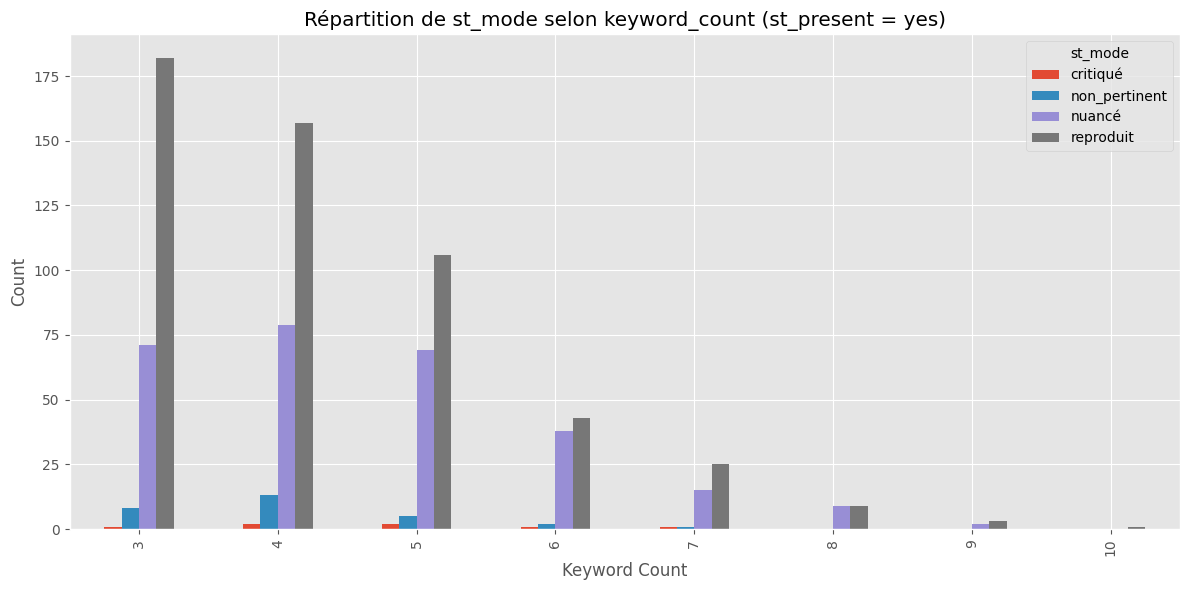

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter rows where st_present == "yes"
filtered = sr_ready[sr_ready["st_present"] == "yes"]

plt.style.use("ggplot")  # Using a matplotlib style as requested

# Create a pivot table for counts
pivot = filtered.pivot_table(
    index="keyword_count", columns="st_mode", aggfunc="size", fill_value=0
)

# Plot
pivot.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Keyword Count")
plt.ylabel("Count")
plt.title("Répartition de st_mode selon keyword_count (st_present = yes)")
plt.tight_layout()

plt.show()


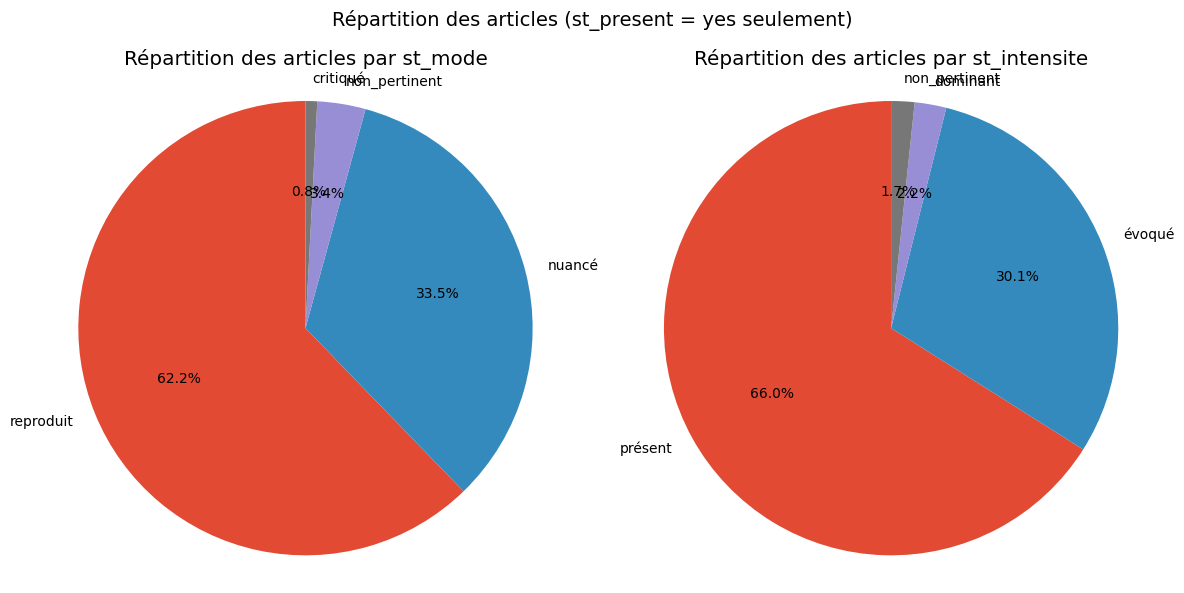

In [125]:
import matplotlib.pyplot as plt
import pandas as pd

# ===== Toggle here =====
# Set to True if you only want rows where st_present == "yes"
# Set to False to use ALL rows
filter_present = True
# =======================

if filter_present:
    df = sr_ready[sr_ready["st_present"] == "yes"].copy()
else:
    df = sr_ready.copy()

plt.style.use("ggplot")  # nice-looking style

# Prepare figure with two pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ---- Pie chart for st_mode ----
mode_counts = df["st_mode"].value_counts()

axes[0].pie(mode_counts, labels=mode_counts.index, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Répartition des articles par st_mode")
axes[0].axis("equal")  # make pie a circle

# ---- Pie chart for st_intensite ----
intensite_counts = df["st_intensite"].value_counts()

axes[1].pie(
    intensite_counts, labels=intensite_counts.index, autopct="%1.1f%%", startangle=90
)
axes[1].set_title("Répartition des articles par st_intensite")
axes[1].axis("equal")

# Overall title, with reminder of filter
filter_label = (
    " (st_present = yes seulement)" if filter_present else " (tous les articles)"
)
fig.suptitle("Répartition des articles" + filter_label, fontsize=14)

plt.tight_layout()
plt.show()


In [46]:
font = load_google_font("Libertinus Serif", danger_not_verify_ssl=True)
print(font)

sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:file=/home/artamis/.cache/pyfontsloader/bed376ccee8533f7b571bc0900cc0cabe1b01d49e723b77d1325da696a5262e0.ttf:size=10.0


In [49]:
def load_arctic_light_with_libertinus():
    """
    Return an aquarel Theme based on 'arctic_light'
    but using Google Fonts 'Libertinus Serif' as the
    default Matplotlib font (loaded via pyfonts).
    """
    # 1) Download & register the Libertinus Serif font from Google Fonts
    libertinus_fp = load_google_font("Libertinus Serif")
    libertinus_name = libertinus_fp.get_name()  # e.g. "Libertinus Serif"

    # 2) Start from the built-in arctic_light theme
    #    and override its font settings to use Libertinus
    theme = load_theme("arctic_light").set_font(
        family="serif",  # use the 'serif' family everywhere
        serif=[libertinus_name],  # and make that family be Libertinus Serif
    )

    # Optionally you can save it for reuse as a JSON theme:
    # theme.save("arctic_light_libertinus.json")

    return theme


In [50]:
theme = load_arctic_light_with_libertinus()
theme.apply()

findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
f

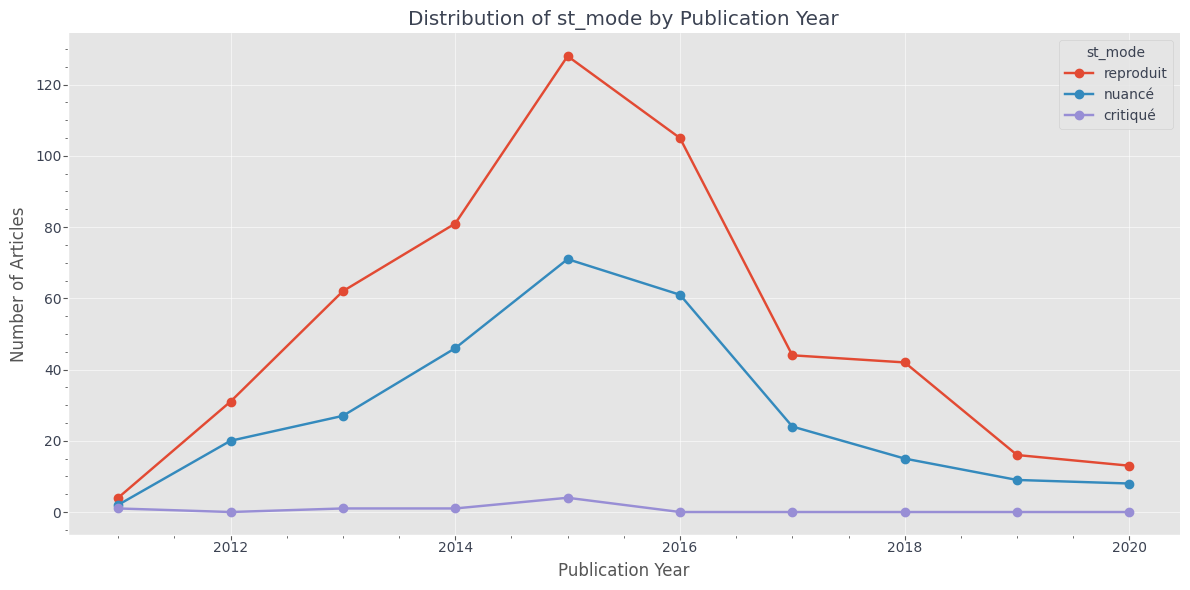

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure pub_date is datetime
sr_ready["pub_date"] = pd.to_datetime(sr_ready["pub_date"], errors="coerce")

# Extract publication year
sr_ready["pub_year"] = sr_ready["pub_date"].dt.year

# Keep only the 3 main st_mode categories
modes_to_keep = ["reproduit", "nuancé", "critiqué"]
df = sr_ready[sr_ready["st_mode"].isin(modes_to_keep)]

# Count rows per year & st_mode
counts = df.groupby(["pub_year", "st_mode"]).size().unstack(fill_value=0)

plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

# Plot one curve per st_mode
for mode in modes_to_keep:
    if mode in counts.columns:
        plt.plot(counts.index, counts[mode], marker="o", label=mode)

plt.xlabel("Publication Year")
plt.ylabel("Number of Articles")
plt.title("Distribution of st_mode by Publication Year")
plt.legend(title="st_mode")
plt.tight_layout()
plt.show()


In [ ]:
sr_ready = combined_df.copy()
sr_ready.info()
# sr_ready = sr_ready[sr_ready["st_intensite"].isin(["évoqué"])]
# sr_ready = sr_ready[sr_ready["keyword_count"] >= 5]
sr_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1922 non-null   int64 
 1   pub_date           1922 non-null   object
 2   feed               1922 non-null   object
 3   category           1922 non-null   object
 4   keyword            1904 non-null   object
 5   signature          1922 non-null   object
 6   title              1922 non-null   object
 7   text_html          1922 non-null   object
 8   text_cleaned       1922 non-null   object
 9   test_preprocessed  1922 non-null   object
 10  keyword_count      1922 non-null   int64 
 11  st_present         1922 non-null   object
 12  st_mode            1922 non-null   object
 13  st_intensite       1922 non-null   object
 14  st_resume          1922 non-null   object
 15  st_justification   1922 non-null   object
 16  st_raw_response    0 non-null      object


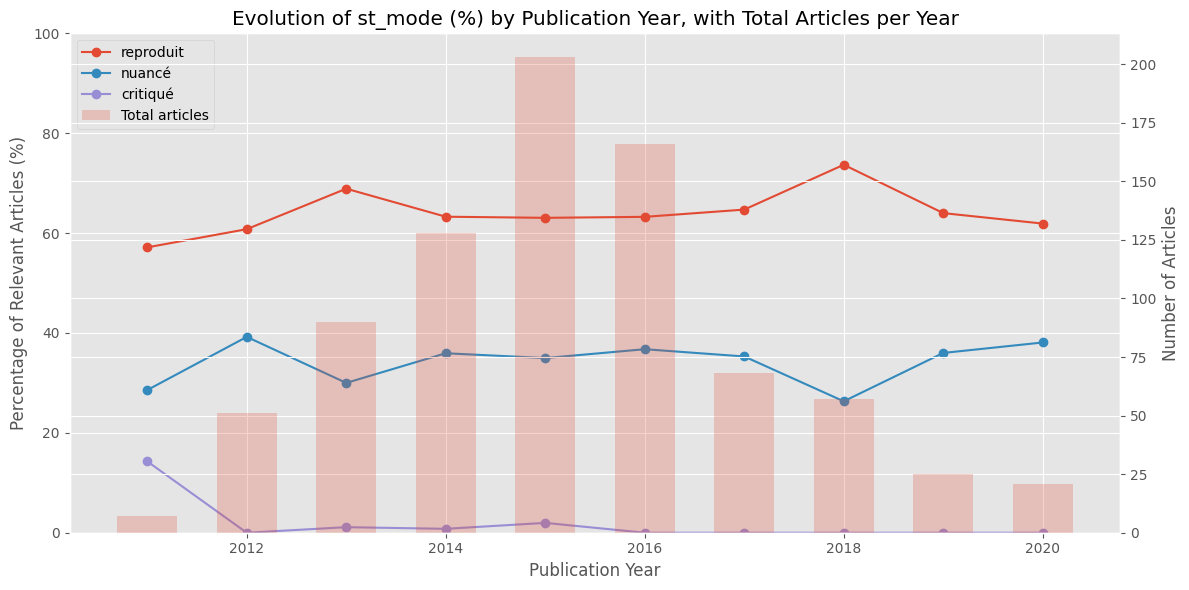

In [153]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure pub_date is datetime
sr_ready["pub_date"] = pd.to_datetime(sr_ready["pub_date"], errors="coerce")

# Extract publication year
sr_ready["pub_year"] = sr_ready["pub_date"].dt.year

# Keep only the 3 relevant st_mode categories
modes_to_keep = ["reproduit", "nuancé", "critiqué"]
df = sr_ready[sr_ready["st_mode"].isin(modes_to_keep)]

# Count articles per year and st_mode
counts = df.groupby(["pub_year", "st_mode"]).size().unstack(fill_value=0)

# Total relevant articles per year
totals = counts.sum(axis=1)

# Percentages per year
percentages = counts.div(totals, axis=0) * 100

plt.style.use("ggplot")
fig, ax1 = plt.subplots(figsize=(12, 6))

# ---- Percentage curves (left axis) ----
for mode in modes_to_keep:
    if mode in percentages.columns:
        ax1.plot(percentages.index, percentages[mode], marker="o", label=mode)

ax1.set_xlabel("Publication Year")
ax1.set_ylabel("Percentage of Relevant Articles (%)")
ax1.set_ylim(0, 100)

# ---- Bar chart for total articles (right axis) ----
ax2 = ax1.twinx()
ax2.bar(totals.index, totals.values, alpha=0.25, width=0.6, label="Total articles")
ax2.set_ylabel("Number of Articles")

# ---- Legends ----
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(
    lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1], loc="upper left"
)

plt.title("Evolution of st_mode (%) by Publication Year, with Total Articles per Year")
plt.tight_layout()
plt.show()


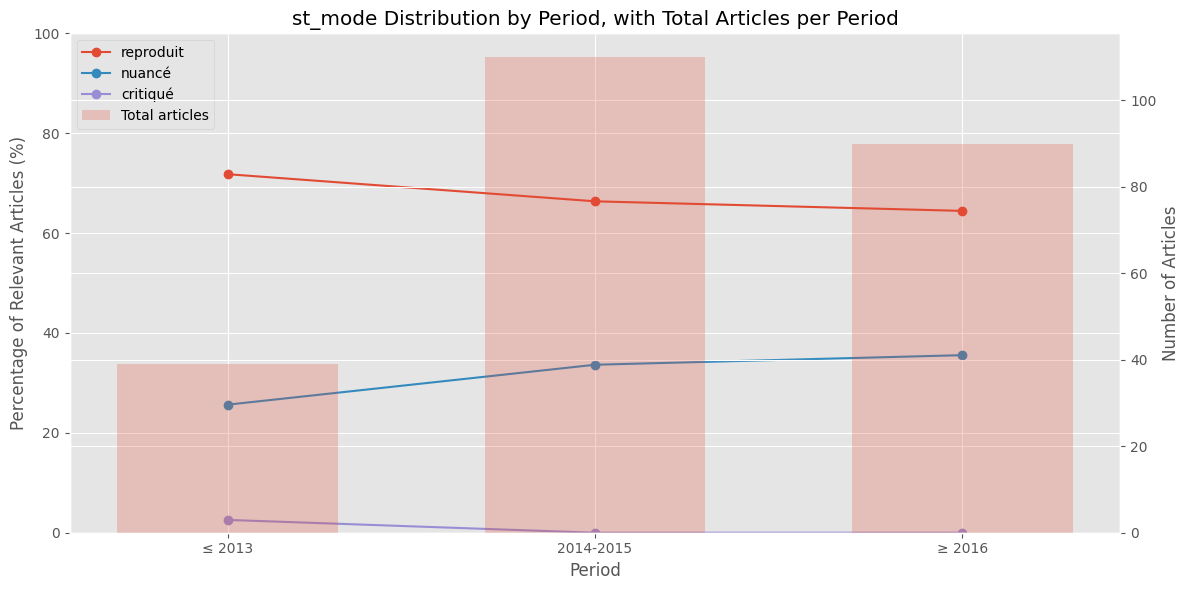

In [150]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure pub_date is datetime
sr_ready["pub_date"] = pd.to_datetime(sr_ready["pub_date"], errors="coerce")

# Extract publication year
sr_ready["pub_year"] = sr_ready["pub_date"].dt.year


# ----------------------------------------------------
# DEFINE PERIODS HERE — customize as you want
# ----------------------------------------------------
def year_to_period(year):
    if year <= 2013:
        return "≤ 2013"
    elif 2014 <= year <= 2015:
        return "2014-2015"
    else:
        return "≥ 2016"


sr_ready["period"] = sr_ready["pub_year"].apply(year_to_period)
# ----------------------------------------------------

# Keep only the 3 relevant st_mode categories
modes_to_keep = ["reproduit", "nuancé", "critiqué"]
df = sr_ready[sr_ready["st_mode"].isin(modes_to_keep)]

# Count articles per period and st_mode
counts = df.groupby(["period", "st_mode"]).size().unstack(fill_value=0)

# Total relevant articles per period
totals = counts.sum(axis=1)

# Percentages per period
percentages = counts.div(totals, axis=0) * 100

# Ensure periods appear in correct chronological order
period_order = ["≤ 2013", "2014-2015", "≥ 2016"]
percentages = percentages.reindex(period_order)
totals = totals.reindex(period_order)

plt.style.use("ggplot")
fig, ax1 = plt.subplots(figsize=(12, 6))

# ---- Percentage curves (left axis) ----
for mode in modes_to_keep:
    if mode in percentages.columns:
        ax1.plot(percentages.index, percentages[mode], marker="o", label=mode)

ax1.set_xlabel("Period")
ax1.set_ylabel("Percentage of Relevant Articles (%)")
ax1.set_ylim(0, 100)

# ---- Bar chart for total articles (right axis) ----
ax2 = ax1.twinx()
ax2.bar(totals.index, totals.values, alpha=0.25, width=0.6, label="Total articles")
ax2.set_ylabel("Number of Articles")

# ---- Legends ----
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(
    lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1], loc="upper left"
)

plt.title("st_mode Distribution by Period, with Total Articles per Period")
plt.tight_layout()
plt.show()


In [151]:
# Filter articles with st_mode = "critiqué"
critique_df = sr_ready[sr_ready["st_mode"] == "nuancé"]

print(critique_df)

# Pretty print the relevant columns
for idx, row in critique_df.iterrows():
    print("──────────────────────────────────────────────")
    print(f"TITLE:\n{row['title']}\n")
    print(f"RÉSUMÉ:\n{row['st_resume']}\n")
    print(f"JUSTIFICATION:\n{row['st_justification']}\n")


            id            pub_date      feed category       keyword  \
92     9165825 2015-12-16 09:39:46  RTBFINFO    MONDE        EUROPE   
122    8155070 2013-12-11 11:01:00  RTBFINFO    MONDE  MOYEN ORIENT   
146    8363444 2014-09-25 08:02:00  RTBFINFO    MONDE  MOYEN ORIENT   
147    9627864 2017-06-07 20:46:22  RTBFINFO    MONDE  MOYEN ORIENT   
158    8390677 2014-10-31 08:01:00  RTBFINFO    MONDE  MOYEN ORIENT   
...        ...                 ...       ...      ...           ...   
1846  10341506 2019-10-14 21:49:00  RTBFINFO    MONDE  MOYEN ORIENT   
1888   9110001 2015-10-16 14:51:00  RTBFINFO    MONDE        DIVERS   
1893   9166893 2015-12-17 11:50:00  RTBFINFO    MONDE        EUROPE   
1913  10400956 2020-01-06 20:28:00  RTBFINFO    MONDE  MOYEN ORIENT   
1915  10429908 2020-02-11 09:02:06  RTBFINFO    MONDE        DIVERS   

                  signature  \
92                      AFP   
122          Wahoub Fayoumi   
146   Jean-François Herbecq   
147                    

In [85]:
print(sr_ready.iloc[0]["title"])
print(sr_ready.iloc[0]["st_resume"])
print(sr_ready.iloc[0]["st_justification"])

Liban: journée de deuil national après l'attentat de l'EI ayant fait 43 morts
L'article traite d'un attentat au Liban revendiqué par l'EI, lié au conflit syrien. Le Hezbollah est mentionné pour son soutien au régime de Bachar al-Assad contre les rebelles et les djihadistes en Syrie.
L'article reproduit l'idée reçue en mentionnant que le Hezbollah combat en Syrie aux côtés du régime de Bachar al-Assad contre les djihadistes, impliquant que sans ce soutien, la situation serait pire. Cela efface la diversité des acteurs et la complexité du conflit syrien.


In [17]:
import json
import re
from typing import Any, Dict, List

import requests

OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "mistral:7b"  # or "llama3:8b", "mistral", etc.

In [18]:
stereotype_id = "assad_vs_daech"
stereotype = stereotypes[stereotype_id]

In [ ]:
def analyze_chunk_with_ollama(
    text: str,
    stereotype_id: str,
    stereotype: Dict[str, Any],
    model: str = MODEL_NAME,
    url: str = OLLAMA_URL,
    temperature: float = 0.1,
    timeout: int = 120,
) -> Dict[str, Any]:
    prompt = build_prompt_for_chunk(text, stereotype_id, stereotype)

    payload = {
        "model": model,
        "prompt": prompt,
        "format": "json",  # on demande du JSON directement
        "stream": False,
        "options": {"temperature": temperature},
    }

    resp = requests.post(url, json=payload, timeout=timeout)
    resp.raise_for_status()

    raw_response = resp.json().get("response", "").strip()

    try:
        data = json.loads(raw_response)
    except json.JSONDecodeError:
        data = {"error": "json_decode_error", "raw": raw_response}

    return data


In [ ]:
def analyze_issue_for_stereotype_focus(
    full_text: str,
    stereotype_id: str,
    stereotype: Dict[str, Any],
) -> Dict[str, Any]:
    """
    Analyse un journal (texte complet) pour un stéréotype donné,
    en ne sélectionnant qu'un chunk "focal" autour des mots-clés.

    Retourne :
    - score_presence (ou 0.0 si pas de résultat)
    - mode
    - le chunk utilisé, pour inspection
    - le résultat brut du LLM
    """
    focus_chunk = full_text

    if not focus_chunk.strip():
        return {
            "stereotype_id": stereotype_id,
            "score_presence": 0.0,
            "mode": "non_pertinent",
            "chunk": "",
            "llm_result": None,
        }

    res = analyze_chunk_with_ollama(focus_chunk, stereotype_id, stereotype)

    if isinstance(res, dict) and "score_presence" in res and not res.get("error"):
        return {
            "stereotype_id": stereotype_id,
            "score_presence": res.get("score_presence", 0.0),
            "mode": res.get("mode", "non_pertinent"),
            "chunk": focus_chunk,
            "llm_result": res,
        }
    else:
        return {
            "stereotype_id": stereotype_id,
            "score_presence": 0.0,
            "mode": "non_pertinent",
            "chunk": focus_chunk,
            "llm_result": res,
        }


In [ ]:
stereotype_id = "assad_vs_daech"
stereotype = stereotypes[stereotype_id]


def analyze_row_focus(row):
    text = row["text_cleaned"]
    return analyze_issue_for_stereotype_focus(
        full_text=text,
        stereotype_id=stereotype_id,
        stereotype=stereotype,
    )


sr_keywords["llm_assad_vs_daech"] = sr_keywords.progress_apply(
    analyze_row_focus, axis=1
)

  0%|          | 0/57 [00:00<?, ?it/s]

/tmp/ipykernel_9990/741118110.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["llm_assad_vs_daech"] = sr_keywords.progress_apply(analyze_row_focus, axis=1)


In [50]:
sr_keywords["assad_vs_daech_score"] = sr_keywords["llm_assad_vs_daech"].apply(
    lambda d: d.get("score_presence", 0.0) if isinstance(d, dict) else 0.0
)

sr_keywords["assad_vs_daech_mode"] = sr_keywords["llm_assad_vs_daech"].apply(
    lambda d: d.get("mode", "non_pertinent") if isinstance(d, dict) else "non_pertinent"
)

/tmp/ipykernel_9990/2000915364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["assad_vs_daech_score"] = sr_keywords["llm_assad_vs_daech"].apply(
/tmp/ipykernel_9990/2000915364.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["assad_vs_daech_mode"] = sr_keywords["llm_assad_vs_daech"].apply(


In [ ]:
sr_assad = sr_keywords.sort_values(by=["assad_vs_daech_score"], ascending=False)

In [67]:
sr_assad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 516794 to 706107
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    57 non-null     int64         
 1   pub_date              57 non-null     datetime64[ns]
 2   feed                  57 non-null     object        
 3   category              57 non-null     object        
 4   keyword               55 non-null     object        
 5   signature             57 non-null     object        
 6   title                 57 non-null     object        
 7   text_html             57 non-null     object        
 8   text_cleaned          57 non-null     object        
 9   test_preprocessed     57 non-null     object        
 10  keyword_count         57 non-null     int64         
 11  llm_assad_vs_daech    57 non-null     object        
 12  assad_vs_daech_score  57 non-null     float64       
 13  assad_vs_daech_mod

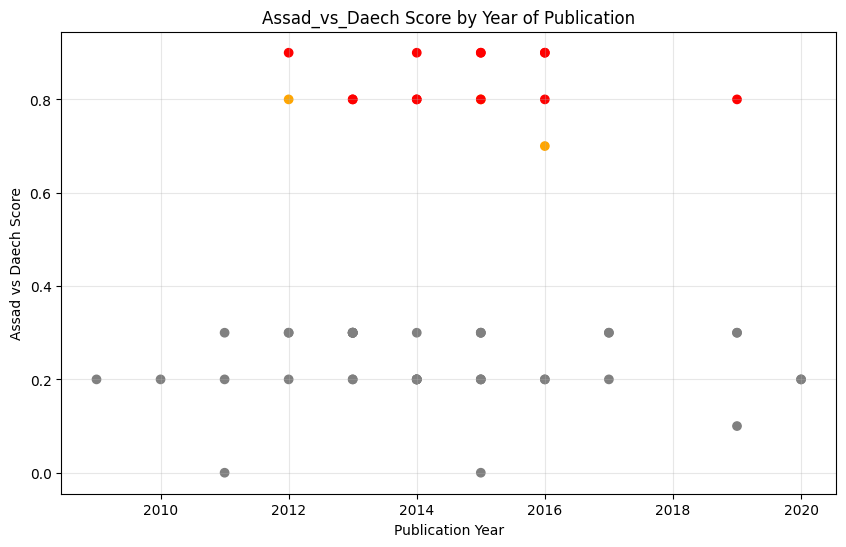

In [ ]:
import matplotlib.pyplot as plt

# Extract publication year
sr_assad["year"] = sr_assad["pub_date"].dt.year

# Color mapping
color_map = {
    "reproduit": "red",
    "nuancé": "orange",
    "critiqué": "green",
    "non_pertinent": "grey",
}

# Assign colors based on the mode
colors = sr_assad["assad_vs_daech_mode"].map(color_map)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sr_assad["year"], sr_assad["assad_vs_daech_score"], c=colors)

plt.xlabel("Publication Year")
plt.ylabel("Assad vs Daech Score")
plt.title("Assad_vs_Daech Score by Year of Publication")

# Optional: show grid
plt.grid(True, alpha=0.3)

plt.show()


In [77]:
sr_keywords.loc[sr_keywords["assad_vs_daech_mode"] == "nuancé"]["text_cleaned"].iloc[0]

'La coalition internationale antidjihadistes menée par les Etats-Unis a admis samedi avoir bombardé ce qu\'elle pensait être une position du groupe Etat islamique (EI) en Syrie, tuant au moins 60 soldats syriens et provoquant une réunion du Conseil de sécurité de l\'ONU.\n\nLes Etats-Unis ont exprimé samedi leurs "regrets" à la Russie, a dit un responsable de l\'administration Obama. Les Etats-Unis vont continuer d\'observer la trêve en vigueur en Syrie tout en poursuivant leurs opérations militaires contre l\'organisation Etat islamique et Al Qaïda, écrit ce responsable dans un courriel.\n\nUne trêve mise à mal\n\nCe bombardement meurtrier est intervenu au cinquième jour d\'une fragile trêve issue d\'un accord entre les Etats-Unis et la Russie. Dans la foulée, Moscou a accusé samedi soir l\'"opposition modérée" syrienne, soutenue par les Etats-Unis, d\'avoir "fait échouer" ce cessez-le-feu.\n\nCette trêve avait déjà été mise à mal vendredi avec de violents combats et des civils tués d